In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

import KAN_Network
from torchvision.datasets import MNIST, FashionMNIST
from KANConv import KAN_Convolutional_Layer, KANLinear


In [59]:
# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
mnist_train = FashionMNIST(root='./data', train=True, download=True, transform=transform)

mnist_test = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

ValueError: The original URL is broken so the StanfordCars dataset is not available for automatic download anymore. You can try to download it manually following https://github.com/pytorch/vision/issues/7545#issuecomment-1631441616, and set download=False to avoid this error.

In [4]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    # Set the model to training mode
    model.to(device)
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion):
    # Switch the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    return test_loss, accuracy, precision, recall, f1

## Modelos Comunes

In [51]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Capa convolucional, asumiendo una entrada con 1 canal (imagen en escala de grises)
        # y produciendo 16 canales de salida, con un kernel de tamaño 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, padding=1)
        
        # Capa de MaxPooling, utilizando un kernel de tamaño 2x2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Capa lineal (Fully Connected)
        # Suponiendo una entrada de imagen de tamaño 28x28, después de conv y maxpool, será 14x14
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * 14 * 14, 10)

    def forward(self, x):
        # Aplicar la capa convolucional seguida de activación ReLU
        x = F.relu(self.conv1(x))
        # Aplicar max pooling
        x = self.maxpool(x)
        # Aplanar los datos
        x = self.flatten(x)
        # Capa lineal con 10 salidas
        x = self.fc(x)
        return x

class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        # Definir una sola capa lineal con 'input_features' entradas y 10 salidas
        self.linear = nn.Linear(28*28, 10)
        self.flatten = nn.Flatten()


    def forward(self, x):
        # Pasar los datos a través de la capa lineal
        x = self.flatten(x)
        x = self.linear(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Primera capa convolucional y segunda con el mismo padding y tamaño de kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')

        # Segunda serie de capas convolucionales
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        # Capas de MaxPooling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capas de Dropout
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)

        # Capa completamente conectada
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # 64 canales, tamaño de imagen reducido a 7x7
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Aplicar las primeras capas convolucionales y pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout1(x)

        # Aplicar las segundas capas convolucionales y pooling
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.dropout2(x)

        # Aplanar los datos para la entrada a las capas densas
        x = torch.flatten(x, 1)  # Aplanar todo excepto el batch
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        # Aplicar softmax para obtener las probabilidades de las clases
        x = F.log_softmax(x, dim=1)
        return x


## Modelos Propios

In [52]:

class KAN_CONVS_2Kan_linears(nn.Module):
    def __init__(self,device  = "cuda"):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs = 2,
            kernel_size= (2,2),
            stride =  (1,1),
            padding=(0,0),
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
            device = device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs = 2,
            kernel_size= (2,2),
            stride =  (1,1),
            padding=(0,0),
            grid_size=7,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
            device = device
        )

        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flat = nn.Flatten() 
        
        self.kan1 = KANLinear(
            144,
            20,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )
        self.kan2 = KANLinear(
            20,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
    
        x = self.kan1(x) 
        x = self.kan2(x)
        return x
    

In [54]:
# Instanciar el modelo
# model = SimpleCNN()
# model = SimpleLinear()
model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


# Define loss
criterion = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)
        scheduler.step()
        print('')
        print("lr: ", optimizer.param_groups[0]['lr'])
        print("test loss: ", test_loss)
        print("accuracy: ", accuracy)
        print("precision: ", precision)
        print("recall: ", recall)
        print("f1: ", f1)
        print('')


Training on cuda
Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:58<00:00, 16.08it/s]


Training set: Average loss: 0.504604

Test set: Average loss: 0.0053, Accuracy: 8752/10000 (88%), Precision: 0.88, Recall: 0.88, F1 Score: 0.87


lr:  0.0008
test loss:  0.0053211491607129575
accuracy:  87.52
precision:  0.8754871891401542
recall:  0.8752000000000001
f1:  0.8723446064370746

Epoch: 2


100%|██████████| 938/938 [01:00<00:00, 15.53it/s]


Training set: Average loss: 0.324908

Test set: Average loss: 0.0043, Accuracy: 8997/10000 (90%), Precision: 0.90, Recall: 0.90, F1 Score: 0.90


lr:  0.00064
test loss:  0.004317204716801643
accuracy:  89.97
precision:  0.8986521331388625
recall:  0.8996999999999999
f1:  0.8984938169031658

Epoch: 3


100%|██████████| 938/938 [01:11<00:00, 13.13it/s]


Training set: Average loss: 0.275246

Test set: Average loss: 0.0040, Accuracy: 9031/10000 (90%), Precision: 0.90, Recall: 0.90, F1 Score: 0.90


lr:  0.0005120000000000001
test loss:  0.004016432368755341
accuracy:  90.31
precision:  0.9043670406566836
recall:  0.9030999999999999
f1:  0.902981079739299

Epoch: 4


100%|██████████| 938/938 [01:09<00:00, 13.57it/s]


Training set: Average loss: 0.242810

Test set: Average loss: 0.0039, Accuracy: 9098/10000 (91%), Precision: 0.91, Recall: 0.91, F1 Score: 0.91


lr:  0.0004096000000000001
test loss:  0.003898207199573517
accuracy:  90.98
precision:  0.9108697354421811
recall:  0.9098
f1:  0.9098424322172407

Epoch: 5


100%|██████████| 938/938 [00:54<00:00, 17.22it/s]


Training set: Average loss: 0.220217

Test set: Average loss: 0.0035, Accuracy: 9164/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92


lr:  0.0003276800000000001
test loss:  0.0035449701078236104
accuracy:  91.64
precision:  0.9165703804591965
recall:  0.9164
f1:  0.9156831699738295

Epoch: 6


100%|██████████| 938/938 [00:55<00:00, 16.81it/s]


Training set: Average loss: 0.204739

Test set: Average loss: 0.0035, Accuracy: 9215/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92


lr:  0.0002621440000000001
test loss:  0.0034502703465521334
accuracy:  92.15
precision:  0.9222441693751721
recall:  0.9215
f1:  0.9217593451584044

Epoch: 7


100%|██████████| 938/938 [01:04<00:00, 14.51it/s]


Training set: Average loss: 0.190065

Test set: Average loss: 0.0034, Accuracy: 9229/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92


lr:  0.00020971520000000012
test loss:  0.0033743953745812177
accuracy:  92.29
precision:  0.9224148973836179
recall:  0.9228999999999999
f1:  0.9221716642934584

Epoch: 8


100%|██████████| 938/938 [01:07<00:00, 13.92it/s]


Training set: Average loss: 0.179364

Test set: Average loss: 0.0033, Accuracy: 9250/10000 (92%), Precision: 0.92, Recall: 0.93, F1 Score: 0.92


lr:  0.0001677721600000001
test loss:  0.003332032078504562
accuracy:  92.5
precision:  0.9248475781887173
recall:  0.925
f1:  0.9247972164466773

Epoch: 9


100%|██████████| 938/938 [01:27<00:00, 10.73it/s]


Training set: Average loss: 0.168342

Test set: Average loss: 0.0033, Accuracy: 9265/10000 (93%), Precision: 0.93, Recall: 0.93, F1 Score: 0.93


lr:  0.00013421772800000008
test loss:  0.0033001160338521005
accuracy:  92.65
precision:  0.9261934948659789
recall:  0.9264999999999999
f1:  0.9262449149783241

Epoch: 10


100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


Training set: Average loss: 0.162181

Test set: Average loss: 0.0033, Accuracy: 9276/10000 (93%), Precision: 0.93, Recall: 0.93, F1 Score: 0.93


lr:  0.00010737418240000007
test loss:  0.003293988785892725
accuracy:  92.76
precision:  0.9274075102165371
recall:  0.9276
f1:  0.9273381868267977



In [55]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = KAN_Network.KAN_Convolutional_Network()#KAN_CONVS_2Kan_linears()
print("CKAN: ",count_parameters(model))

model2 = ConvNet()
print("ConvNet: ",count_parameters(model2))


CKAN:  46376
ConvNet:  887530


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAN_Network.KAN_Convolutional_Network(device = device)
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


# Define loss
criterion = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 6
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)
        scheduler.step()
        print('')
        print("lr: ", optimizer.param_groups[0]['lr'])
        print("test loss: ", test_loss)
        print("accuracy: ", accuracy)
        print("precision: ", precision)
        print("recall: ", recall)
        print("f1: ", f1)
        print('')


Training on cuda
Epoch: 1


100%|██████████| 938/938 [03:39<00:00,  4.28it/s]


Training set: Average loss: 0.768507

Test set: Average loss: 0.0071, Accuracy: 8355/10000 (84%), Precision: 0.83, Recall: 0.84, F1 Score: 0.83


lr:  0.0008
test loss:  0.007102931821346283
accuracy:  83.55
precision:  0.8345363890305734
recall:  0.8355
f1:  0.8336549479633554

Epoch: 2


100%|██████████| 938/938 [03:31<00:00,  4.44it/s]


Training set: Average loss: 0.403833

Test set: Average loss: 0.0063, Accuracy: 8521/10000 (85%), Precision: 0.85, Recall: 0.85, F1 Score: 0.85


lr:  0.00064
test loss:  0.006344194158911705
accuracy:  85.21
precision:  0.8509275426914487
recall:  0.8520999999999999
f1:  0.8480195950085265

Epoch: 3


100%|██████████| 938/938 [03:11<00:00,  4.89it/s]


Training set: Average loss: 0.365783

Test set: Average loss: 0.0060, Accuracy: 8588/10000 (86%), Precision: 0.86, Recall: 0.86, F1 Score: 0.86


lr:  0.0005120000000000001
test loss:  0.005970777127146721
accuracy:  85.88
precision:  0.8586002211335808
recall:  0.8587999999999999
f1:  0.8583068455150873

Epoch: 4


100%|██████████| 938/938 [03:11<00:00,  4.90it/s]


Training set: Average loss: 0.345159

Test set: Average loss: 0.0059, Accuracy: 8634/10000 (86%), Precision: 0.86, Recall: 0.86, F1 Score: 0.86


lr:  0.0004096000000000001
test loss:  0.005893851698935032
accuracy:  86.34
precision:  0.8620321248391278
recall:  0.8633999999999998
f1:  0.8611936527423572

Epoch: 5


100%|██████████| 938/938 [03:11<00:00,  4.89it/s]


Training set: Average loss: 0.332470

Test set: Average loss: 0.0058, Accuracy: 8639/10000 (86%), Precision: 0.86, Recall: 0.86, F1 Score: 0.86


lr:  0.0003276800000000001
test loss:  0.005767080396413803
accuracy:  86.39
precision:  0.8622436754270227
recall:  0.8639000000000001
f1:  0.862311417053664

Epoch: 6


100%|██████████| 938/938 [03:10<00:00,  4.92it/s]


Training set: Average loss: 0.323055

Test set: Average loss: 0.0057, Accuracy: 8644/10000 (86%), Precision: 0.86, Recall: 0.86, F1 Score: 0.86


lr:  0.0002621440000000001
test loss:  0.005730170094966888
accuracy:  86.44
precision:  0.8623922627936563
recall:  0.8644000000000001
f1:  0.8619214977822331



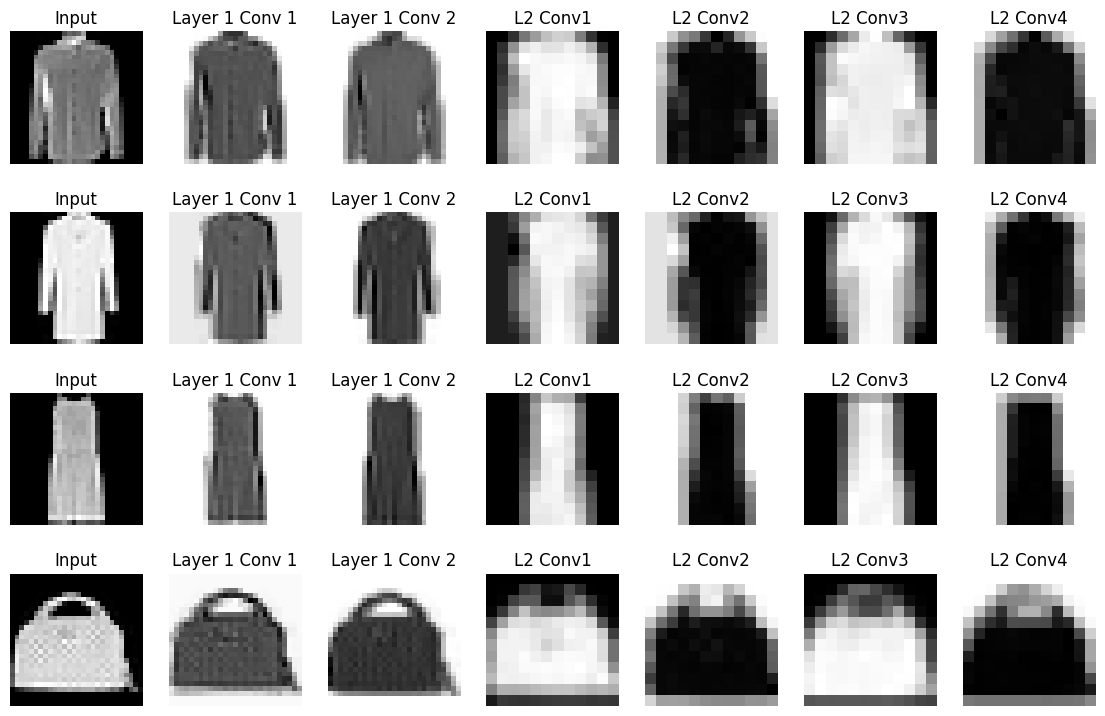

In [50]:
import matplotlib.pyplot as plt
rows =4
pool = nn.MaxPool2d(kernel_size=(2, 2))
ncols = 7   
fig, ax  = plt.subplots(nrows = rows ,ncols = ncols,figsize =(14,9))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        for i in range(ncols):
            ax[row][i].axis("off")
        sample_idx = torch.randint(len(mnist_test), size=(1,)).item()
        img, label = mnist_test[sample_idx]

        post_conv = model.conv1.forward(img.unsqueeze(0).to(device))
        post_conv2 = model.conv2.forward(pool(post_conv)) 
        
        #print(post_conv[0,0].shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("Input")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Layer 1 Conv 1")
        ax[row][2].imshow(post_conv[0,1].cpu(), cmap="gray")
        ax[row][2].set_title("Layer 1 Conv 2")
        for i in range(post_conv2.shape[1]):
            ax[row][3+i].imshow(post_conv2[0,i].cpu(), cmap="gray")
            ax[row][3+i].set_title(f"L2 Conv{i+1}")
